In [1]:
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot
import src.TrafficWorld as tw
np.set_printoptions(precision=2)
import src.IterativeBestResponseMPCMultiple as mibr



###### LATEX Dimensions (Not currently Working)

fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
fig_size = [6, 4]
#################33

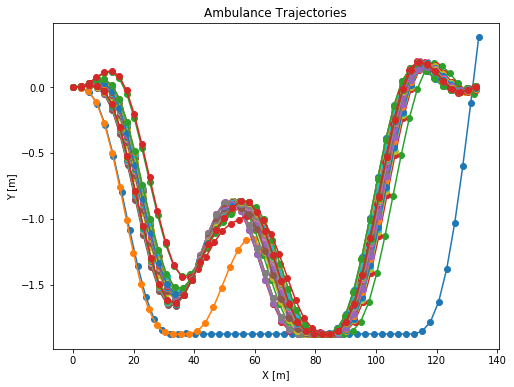

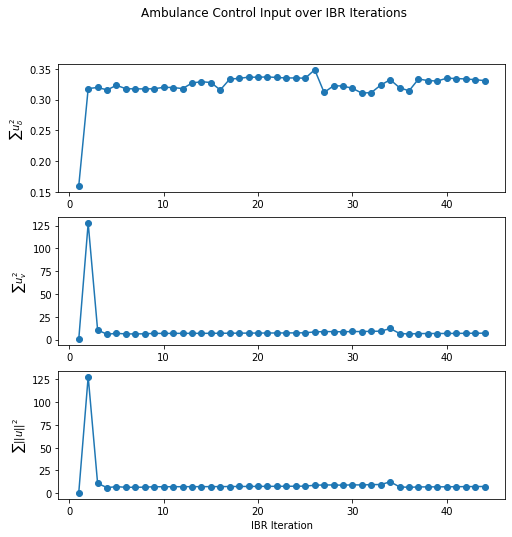

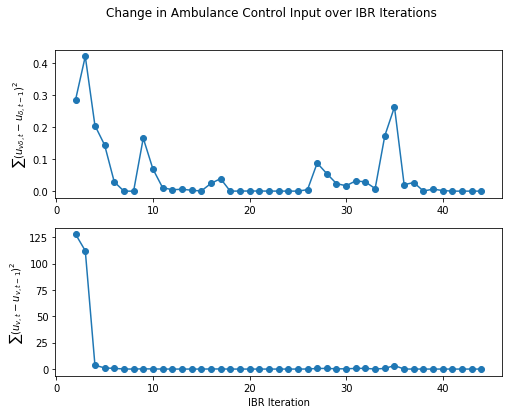

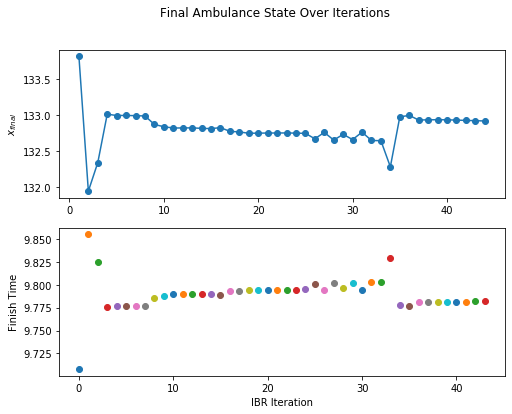

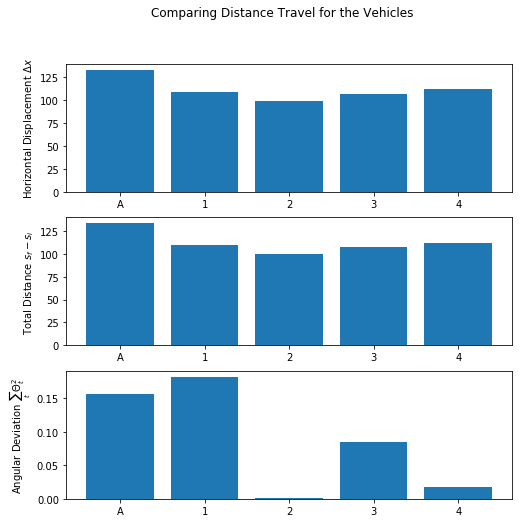

In [45]:
subdir_name = "20200227_133704less_kxdotlarger"
    
list_of_subdirectory_names = [
"20200227_133704less_kxdotlarger",
# "20200227_141954pi2_5altru",
# "20200227_142916pi_01_ego",
# "20200227_143225pi4_pulloversame",
# "20200227_143315pi2_5pulloversame",
# "20200227_145744pi2_5_nograss",
# "20200227_145800pi4_nograss",
# "20200227_145922pi_5dnograss",
# "20200227_161307pi4dnograss_slack",
# "20200227_16521120200227_161307pi4nograss2",
# "20200227_16523520200227_161307pi25altrunograss2",
# "20200227_16533320200227_161307pi5degaltrunograss2",
# "20200227_165619constantV",
# "20200227_170553constantHighSlack",
]
for subdir_name in list_of_subdirectory_names:    
    folder = "results/" + subdir_name + "/"


    ################ Analyze Results

    rounds_ibr = 225
    n_other_cars = 4
    N = 50

    SAVE = False
    PLOT = True

    # ax_xmax = ax_xma[4]


    n_full_rounds = 0  # rounods that the ambulance planned 
    n_all_rounds = 0

    all_xamb = np.zeros((6, N+1, rounds_ibr))
    all_uamb = np.zeros((2, N, rounds_ibr))
    all_xcost = np.zeros((3, rounds_ibr))


    all_other_x = [np.zeros((6, N+1, rounds_ibr)) for i in range(n_other_cars)]
    all_other_u = [np.zeros((2, N, rounds_ibr)) for i in range(n_other_cars)]
    all_other_cost = [np.zeros((3, rounds_ibr)) for i in range(n_other_cars)]
    for amb_ibr_i in range(rounds_ibr):
        if (amb_ibr_i % (n_other_cars + 1) == 1) and amb_ibr_i>1:
            ibr_prefix =  '%03d'%amb_ibr_i
            try:
                xamb, uamb, xamb_des, xothers, uothers, xothers_des = mibr.load_state(folder + "data/" + ibr_prefix, n_other_cars)
                all_xamb[:,:,n_full_rounds] = xamb
                all_uamb[:,:,n_full_rounds] = uamb

                for i in range(n_other_cars):
                    all_other_x[i][:,:,n_full_rounds] = xothers[i] 
                    all_other_u[i][:,:,n_full_rounds] = uothers[i]
                n_full_rounds += 1
            except FileNotFoundError:
                # sssss"amb_ibr_i %d missing"%amb_ibr_i)
                pass
            n_all_rounds += 1
    
    ### Clip the extra dimension
    all_xamb = all_xamb[:,:,:n_full_rounds]
    all_uamb = all_uamb[:,:,:n_full_rounds]
    for i in range(n_other_cars):
        all_other_x[i] = all_other_x[i][:,:,:n_full_rounds]
        all_other_u[i] = all_other_u[i][:,:,:n_full_rounds]
    ibr_brounds_array = np.array(range(1, n_full_rounds +1))


    fig_trajectory, ax_trajectory = plt.subplots(1,1)
    ax_trajectory.set_title("Ambulance Trajectories")
    # fig_trajectory.set_figheight(fig_height)
    # fig_trajectory.set_figwidth(fig_width)
    fig_trajectory.set_size_inches((8,6))
    ax_trajectory.plot(all_xamb[0,:,:], all_xamb[1,:,:], '-o')
    ax_trajectory.set_xlabel("X [m]")
    ax_trajectory.set_ylabel("Y [m]")
    ud = all_uamb[0,:,:]
    if SAVE:
        fig_file_name = folder + 'plots/' + 'fig1_amb_trajectory.eps'
        fig_trajectory.savefig(fig_file_name, dpi=95, format='eps')
        print("Save to....", fig_file_name)

    ##########################################333333

    fig_uamb, ax_uamb = plt.subplots(3,1)
    # fig_uamb.set_figheight(fig_height)
    # fig_uamb.set_figwidth(4)
    fig_uamb.set_size_inches((8,8))
    fig_uamb.suptitle("Ambulance Control Input over IBR Iterations")
    ax_uamb[0].plot(ibr_brounds_array, np.sum(all_uamb[0,:,:] * all_uamb[0,:,:], axis=0), '-o')
    # ax_uamb[0].set_xlabel("IBR Iteration")
    ax_uamb[0].set_ylabel("$\sum u_{\delta}^2$")

    ax_uamb[1].plot(ibr_brounds_array, np.sum(all_uamb[1,:,:] * all_uamb[1,:,:], axis=0), '-o')
    # ax_uamb[1].set_xlabel("IBR Iteration")
    ax_uamb[1].set_ylabel("$\sum u_{v}^2$")

    ax_uamb[2].plot(ibr_brounds_array, np.sum(all_uamb[0,:,:] * all_uamb[0,:,:], axis=0) + np.sum(all_uamb[1,:,:] * all_uamb[1,:,:], axis=0), '-o')
    ax_uamb[2].set_xlabel("IBR Iteration")
    ax_uamb[2].set_ylabel("$\sum ||u||^2$")   

    if SAVE:
        fig_file_name = folder + 'plots/' + 'fig2_amb_ctrl_iterations.eps'
        fig_uamb.savefig(fig_file_name, dpi=95, format='eps')
        print("Save to....", fig_file_name)
        

    ##########################################################3
    fig_reluamb, ax_reluamb = plt.subplots(2,1)
    # fig_reluamb.set_figheight(fig_height)
    # fig_reluamb.set_figwidth(fig_width)
    fig_reluamb.set_size_inches((8,6))
    ax_reluamb[0].plot(ibr_brounds_array[1:], np.sum((all_uamb[0,:,1:]-all_uamb[0,:,0:-1])*(all_uamb[0,:,1:]-all_uamb[0,:,0:-1]), axis=0), '-o')
    # ax_reluamb[0].set_xlabel("IBR Iteration")
    ax_reluamb[0].set_ylabel("$\sum (u_{v\delta,t}-u_{\delta,t-1})^2$")

    ax_reluamb[1].plot(ibr_brounds_array[1:], np.sum((all_uamb[1,:,1:]-all_uamb[1,:,0:-1])*(all_uamb[1,:,1:]-all_uamb[1,:,0:-1]), axis=0), '-o')
    ax_reluamb[1].set_xlabel("IBR Iteration")
    ax_reluamb[1].set_ylabel("$\sum (u_{v,t}-u_{v,t-1})^2$")
    fig_reluamb.suptitle("Change in Ambulance Control Input over IBR Iterations")

    if SAVE:
        fig_file_name = folder + 'plots/' + 'fig3_change_amb_ctrl_iterations.eps'
        fig_reluamb.savefig(fig_file_name, dpi=95, format='eps')
        print("Save to....", fig_file_name)

        

    fig_xfinal, ax_xfinal = plt.subplots(2,1)
    fig_xfinal.suptitle("Final Ambulance State Over Iterations")
    fig_xfinal.set_size_inches((8,6))
    # fig_xfinal.set_figheight(fig_height)
    # fig_xfinal.set_figwidth(fig_width)
    ax_xfinal[0].plot(ibr_brounds_array, all_xamb[0,-1,:], '-o')
    # ax_reluamb[0].set_xlabel("IBR Iteration")
    ax_xfinal[0].set_ylabel("$x_{final}$")
    
    for it in range(all_xamb.shape[2]):
        current_x_state = all_xamb[:,:,it]
        current_x = all_xamb[0,:,it]

        goal_x = 130
        dt = 0.2
        # dt = x_mpc.dt
        i_upper = np.searchsorted(current_x, goal_x)
        i_lower = i_upper - 1

        t_lower = dt*i_lower
        x_lower = current_x[i_lower]
        v_x_lower = np.cos(current_x_state[2, i_lower]) * current_x_state[4, i_lower]
#         print("%.03f %.03f %.03f"%(x_lower, v_x_lower, t_lower))
        distance_travel_from_lower = goal_x - x_lower
        approx_extra_time_to_goal = distance_travel_from_lower/v_x_lower
        finish_time = t_lower + approx_extra_time_to_goal    

        ax_xfinal[1].plot(it, finish_time, '-o')
    ax_xfinal[1].set_xlabel("IBR Iteration")
    ax_xfinal[1].set_ylabel("Finish Time")
    if SAVE:
        fig_file_name = folder + 'plots/' + 'fig4_iterations_ambperformance.eps'
        fig_xfinal.savefig(fig_file_name, dpi=95, format='eps')
        print("Save to....", fig_file_name)

    ###################### NOW PLOTTING THE OTHER VEHICLES #########################3

    fig_xfinal_all, ax_xfinal_all = plt.subplots(3,1)
    fig_xfinal_all.suptitle("Comparing Distance Travel for the Vehicles")
    fig_xfinal_all.set_size_inches((8,8))
    # fig_xfinal_all.set_figheight(fig_height)
    # fig_xfinal_all.set_figwidth(fig_width)
    ax_xfinal_all[0].bar(range(n_other_cars + 1), [all_xamb[0, -1, -1] - all_xamb[0, 0, -1]] + [all_other_x[i][0,-1,-1] - all_other_x[i][0,0,-1] for i in range(n_other_cars)])
    ax_xfinal_all[0].set_ylabel("Horizontal Displacement $\Delta x$")
    ax_xfinal_all[0].set_xticks(range(n_other_cars + 1))
    ax_xfinal_all[0].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

    ax_xfinal_all[1].bar(range(n_other_cars + 1),  [all_xamb[-1, -1, -1] - all_xamb[-1, 0, -1]] + [all_other_x[i][-1,-1,-1] - all_other_x[i][-1,0,-1] for i in range(n_other_cars)])
    ax_xfinal_all[1].set_ylabel("Total Distance $s_f - s_i$")
    ax_xfinal_all[1].set_xticks(range(n_other_cars + 1))
    ax_xfinal_all[1].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

    ax_xfinal_all[2].bar(range(n_other_cars + 1),  [np.sum(all_xamb[2,:,-1]*all_xamb[2,:,-1])] +  [np.sum(all_other_x[i][2,:,-1]*all_other_x[i][2,:,-1]) for i in range(n_other_cars)])
    ax_xfinal_all[2].set_ylabel("Angular Deviation $\sum_{t} \Theta_t^2$")
    ax_xfinal_all[2].set_xticks(range(n_other_cars + 1))
    ax_xfinal_all[2].set_xticklabels(["A"] + [str(i) for i in range(1, n_other_cars+1)])

    if SAVE:
        fig_file_name = folder + 'plots/' + 'fig5_vehicles_comparison.eps'
        fig_xfinal_all.savefig(fig_file_name, dpi=95, format='eps')
        print("Save to....", fig_file_name)


    if PLOT:
        plt.show()

128.578 13.168 9.600


In [40]:
print(finish_time)

9.707965744375828
